<a href="https://colab.research.google.com/github/timothyvanco/machineLearning/blob/master/ML_Learning/under_over_fitting_Colab/cifar10_monitor_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.callbacks import BaseLogger
import matplotlib.pyplot as plt
import numpy as np
import json
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
import argparse

from sklearn.metrics import classification_report

In [0]:
class TrainingMonitor(BaseLogger):
    def __init__(self, figPath, jsonPath=None, startAt=0): # one argument followed by 2 optional ones
        # store output path for figure, path to JSON serialized file, and starting epoch
        super(TrainingMonitor, self).__init__()
        self.figPath = figPath      # path to the output plot that we can use to visualize loss and acc over time
        self.jsonPath = jsonPath    # path to serialize loss and acc values as JSON file - for training history
        self.statAt = startAt       # starting epoch that training is resumed at when using ctrl+c


    def on_train_begin(self, logs={}):
        self.history = {}           # initialize the history dictionary

        # if JSON history path exists, load training history
        if self.jsonPath is not None:
            if os.path.exists(self.jsonPath):
                self.history = json.loads(open(self.jsonPath).read())

                # check to see if a starting epoch was supplied
                if self.startAt > 0:
                    # loop over the entries in the history log and trim any entries that are past the starting epoch
                    for key in self.history.keys():
                        self.history[key] = self.history[key][:self.statAt]

    # epoch - integer representing epoch number, logs - dictionary contains training and validation loss+acc for epoch
    def on_epoch_end(self, epoch, logs={}):
        # loop over the logs and update the loss, acc... for the entire training process
        for (k, v) in logs.items():
            l = self.history.get(k, [])
            l.append(float(v))
            self.history[k] = l

        # check to see if training history should be serialized to file
        if self.jsonPath is not None:
            f = open(self.jsonPath, "w")
            f.write(json.dumps(self.history))
            f.close()

        # ensure at least two epochs have passed before plotting (epoch starts at zero)
        if len(self.history["loss"]) > 1:
            # plot the training loss and acc
            N = np.arange(0, len(self.history["loss"]))
            plt.style.use("ggplot")
            plt.figure()
            plt.plot(N, self.history["loss"], label="train_loss")
            plt.plot(N, self.history["val_loss"], label="val_loss")
            plt.plot(N, self.history["acc"], label="train_acc")
            plt.plot(N, self.history["val_acc"], label="val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(len(self.history["loss"])))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Acc")
            plt.legend()
            plt.show()

In [0]:
class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize model along with input shape to be "channeôs last"
        model = Sequential()
        inputShape = (height, width, depth)
        channelDimension = -1                           # -1 = last ordering

        # if "channels first" update input shape and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            channelDimension = 1                        # batch normalization operatesover channels - in order to apply
                                                        # BN need to know which axis to normalize over, 1 = first order


        # first layer - (CONV => RELU => BN) * 2 => POOL => DO
        model.add(Conv2D(32, (3, 3), padding="same", input_shape = inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))

        model.add(Conv2D(32, (3, 3), padding="same", input_shape = inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))    # node from POOL layer will be randomly disconnected from next layer with prob 25%

        # second layer - (CONV => RELU => BN) * 2 => POOL => DO
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))

        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channelDimension))

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))


        # FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))                   # 512 nodes
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))                 # increasing probability to 50%

        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

In [7]:
print("[INFO] process ID: {}".format(os.getpid()))

# load training and testing data, scale it into the range [0, 1]
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

# convert labels from integers to vectors
labBin = LabelBinarizer()
trainY = labBin.fit_transform(trainY)
testY = labBin.transform(testY)

# initialize label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

print("[INFO] compiling model...")
opt = SGD(lr=0.01, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# construct the set of callbacks
#figPath = os.path.sep.join([args["output"], "{}.png".format(os.getpid())])
#jsonPath = os.path.sep.join([args["output"], "{}.json".format(os.getpid())])
#callbacks = [TrainingMonitor(figPath, jsonPath = jsonPath)]

[INFO] process ID: 427
[INFO] loading CIFAR-10 data...
[INFO] compiling model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
# train network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=100, verbose=1)

[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 11s 216us/sample - loss: 1.6690 - acc: 0.4437 - val_loss: 1.2484 - val_acc: 0.5531
Epoch 2/100
50000/50000 [==============================] - 9s 175us/sample - loss: 1.1917 - acc: 0.5905 - val_loss: 1.3489 - val_acc: 0.5618
Epoch 3/100
50000/50000 [==============================] - 9s 175us/sample - loss: 0.9886 - acc: 0.6580 - val_loss: 1.0876 - val_acc: 0.6331
Epoch 4/100
50000/50000 [==============================] - 9s 174us/sample - loss: 0.8849 - acc: 0.6914 - val_loss: 0.8371 - val_acc: 0.7079
Epoch 5/100
50000/50000 [==============================] - 9s 177us/sample - loss: 0.7982 - acc: 0.7203 - val_loss: 0.7193 - val_acc: 0.7521
Epoch 6/100
50000/50000 [==============================] - 9s 174us/sample - loss: 0.7374 - acc: 0.7429 - val_loss: 0.7179 - val_acc: 0.7466
Epoch 7/100
50000/50000 [==============================] - 9s 175us/sample -

In [9]:
# evaluate network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

    airplane       0.85      0.88      0.87      1000
  automobile       0.92      0.92      0.92      1000
        bird       0.79      0.75      0.77      1000
         cat       0.73      0.62      0.67      1000
        deer       0.80      0.84      0.82      1000
         dog       0.74      0.81      0.77      1000
        frog       0.88      0.88      0.88      1000
       horse       0.89      0.88      0.89      1000
        ship       0.92      0.91      0.91      1000
       truck       0.88      0.91      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



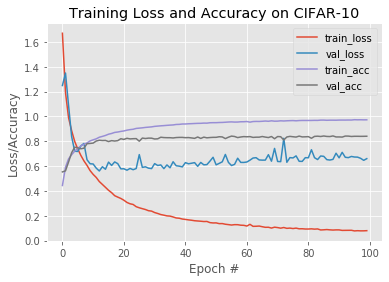

In [10]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
#plt.savefig(args["output"])